In [6]:
!pip install ktrain

# New Section

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline

In [27]:
train_raw = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
train_raw.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
train_raw = train_raw.drop(columns=['keyword', 'location'])
train_raw.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [29]:
train, val, _, _ = train_test_split(train_raw, train_raw, test_size=0.2, random_state=42)

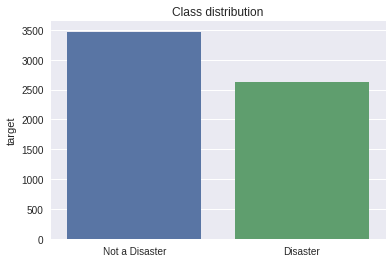

In [30]:
plt.title('Class distribution')
sns.barplot(x=['Not a Disaster','Disaster'], y=train.target.value_counts())

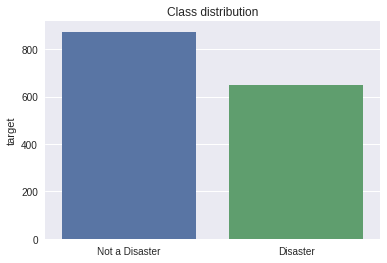

In [31]:
plt.title('Class distribution')
sns.barplot(x=['Not a Disaster','Disaster'], y=val.target.value_counts())

In [32]:
(X_train, y_train), (X_val, y_val), preprocess = text.texts_from_df(train_df=train,
                                                                    text_column='text',
                                                                    label_columns='target',
                                                                    val_df=val,
                                                                    maxlen=128,
                                                                    preprocess_mode='bert')

['not_target', 'target']
      not_target  target
4996         0.0     1.0
3263         1.0     0.0
4907         0.0     1.0
2855         0.0     1.0
4716         1.0     0.0
['not_target', 'target']
      not_target  target
2644         0.0     1.0
2227         1.0     0.0
5448         0.0     1.0
132          1.0     0.0
6845         1.0     0.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [33]:
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preprocess)

Is Multi-Label? False
maxlen is 128
done.


In [34]:
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_val, y_val),
                             batch_size=32)

In [35]:
learner.fit_onecycle(lr=2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
191/191 [==============================] - 224s 1s/step - loss: 0.5668 - accuracy: 0.6926 - val_loss: 0.3900 - val_accuracy: 0.8404


In [36]:
learner

In [37]:
predictor = ktrain.get_predictor(learner.model, preprocess)

In [38]:
test_raw = pd.read_csv('test.csv', dtype={'id': np.int16, 'target': np.int8})
test_raw.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [39]:
truelabels = pd.read_csv('truelabels.csv', dtype={'target':np.int8})
truelabels.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [40]:
predictions = []
for text in test_raw.text:
  predictions.append(predictor.predict(text))

In [41]:
pred_int = []
for i in range(len(predictions)):
    if predictions[i] == 'target':
      pred_int.append(1)
    else:
      pred_int.append(0)

Precision: 0.862 | Recall: 0.709 | F1-Score: 0.778 | Accuracy: 0.826


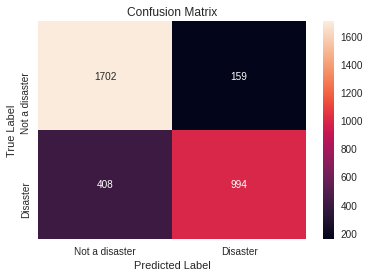

In [42]:
precision, recall, fscore, train_support = score(truelabels.target, pred_int, average='binary')
print('Precision: {} | Recall: {} | F1-Score: {} | Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore, 3), round(accuracy_score(truelabels.target, pred_int), 3)))

cm = confusion_matrix(truelabels.target, pred_int)
class_label = ["Not a disaster", "Disaster"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show() 

In [43]:
predictor.save('/content/disastertweets-bert-base-uncased-maxlen128-batch32-epoch1')

In [44]:
!nvidia-smi

Tue Apr 13 04:27:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    31W /  70W |  14378MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------